**Malaria Detection using CNN**
- project by vivek kothari

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vivekkthtr1","key":"bc8501c2bc5583555931334d6e3b42fe"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets list

In [4]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!ls

 98% 329M/337M [00:04<00:00, 93.4MB/s]
100% 337M/337M [00:04<00:00, 79.3MB/s]
american_sign_language.PNG	       kaggle.json
amer_sign2.png			       sample_data
amer_sign3.png			       sign_mnist_test.csv
cell-images-for-detecting-malaria.zip  sign_mnist_train.csv
drive


In [0]:
!unzip -qq cell-images-for-detecting-malaria.zip

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import os
print(os.listdir("./cell_images/"))

['Parasitized', 'Uninfected']


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda', index=0)

**Data Augmentation**
1. Using Pytorch transformation function to augment a dataset. I tried different transformations but find these helpful.

2. All the images are resized to 120 * 120 as an input to custom CNN class.

3. Applying different transformations like RandomHorizontalFlip( ), RandomRotation( ) etc. There is a 50/50 chance whether it would change the image or not.

4. Converting images into Pytorch tensors.

5. Also normalizing them with mean [0.5, 0.5., 0.5] and standard deviation [0.5, 0.5, 0.5]. All tensors are in range of [-1, 1]. It won't increase size of the dataset as transformation performs one by one on images.

In [0]:
train_transforms = transforms.Compose([transforms.Resize((120, 120)),
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])

**Loading a images using generic dataloader ImageFolder.**

In [0]:
image_dir = "./cell_images/"
train_set = datasets.ImageFolder(image_dir, transform=train_transforms)

**Creating a dataset**

In [11]:
test_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)

test_split = int(np.floor((test_size) * num_train))
test_index, train_index = indices[:test_split - 1], indices[test_split - 1:]

train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)

train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=104)
test_loader = DataLoader(train_set, sampler=test_sampler, batch_size=58)
print("Images in Test set: {}\nImages in Train set: {}".format(len(test_index), len(train_index)))

Images in Test set: 5510
Images in Train set: 22048
Images in Test set: 5510
Images in Train set: 22048


**We have images in 2 classes: Infected and Uninfected**

In [0]:
classes=['infected','uninfected']

**Visualizing some Images...**

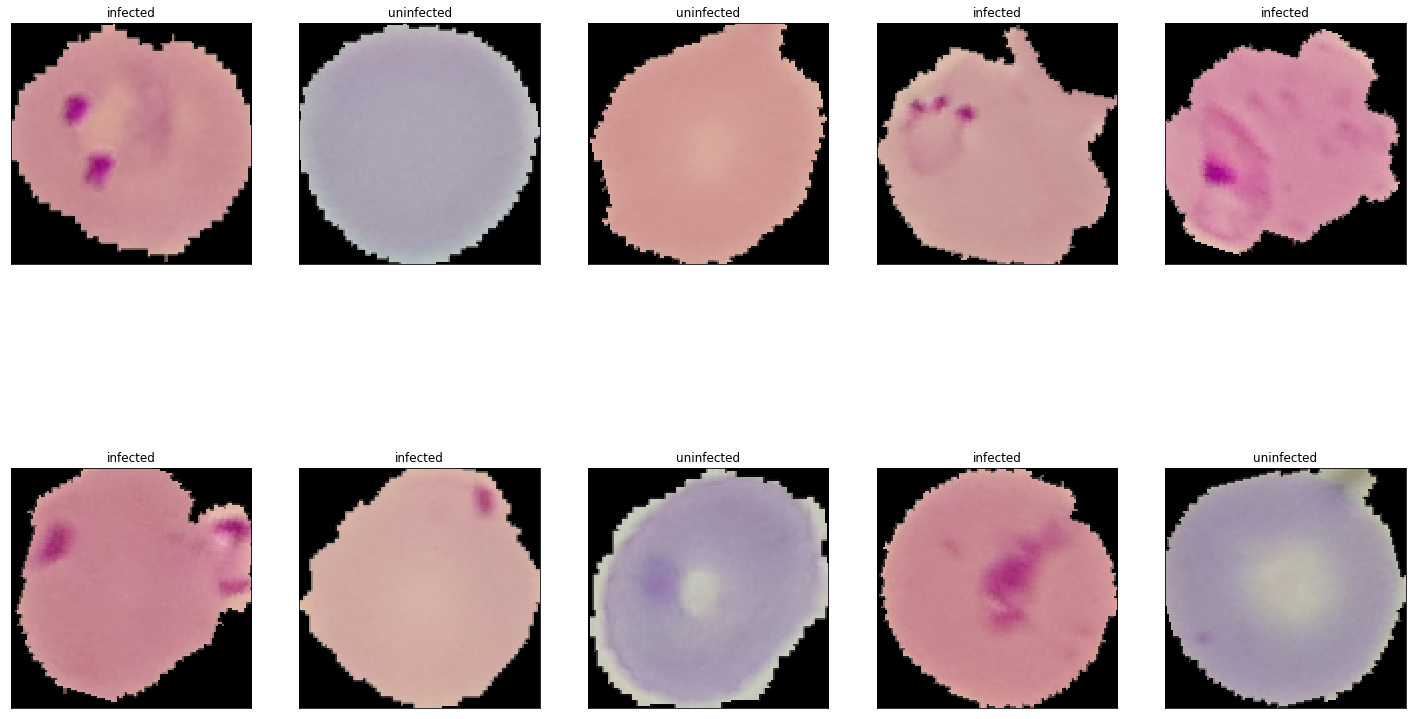

In [15]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 15))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

**CNN class** : 
Creating a CNN class as MosquitoNet.
It has following layers:
* 3 Convolutional layers with MaxPooling (Stride 2)
* All 3 convulations are "Same Convolution with some zero-padding"
* 3 FullyConnected Layers
* BatchNormalization is used after convulations
* ReLU is used as a activation function
* Dropout is used with p = 0.5

Images are changed from input to output layers in following way:

* In Layer 1 : Input: 120 * 120 * 3, Output: 60 * 60 * 16
* In Layer 2 : Input: 60 * 60 * 16, Output: 30 * 30 * 32
* In Layer 3 : Input: 30 * 30 * 32, Output: 15 * 15 * 64
* In FC1 : Input: 14440, Output: 512
* In FC2 : Input: 512, Output: 128
* In FC3 : Input: 128, Output: 2


In [0]:
class MosquitoNet(nn.Module):
    
    def __init__(self):
        super(MosquitoNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
            
        self.fc1 = nn.Linear(64*15*15, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.drop = nn.Dropout2d(0.2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)    # flatten out a input for Dense Layer
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc3(out)
        
        return out
        

**Making a model and defining error and optimizing algorithm.**

In [18]:
model = MosquitoNet()
model.to(device)
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.7)
print(model)

MosquitoNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=14400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=12

**Training a Model**

In [19]:
num_epochs = 20
batch_size = 100 

for epoch in range(num_epochs):
    train_loss = 0.
    model.train()    # explictily stating the training
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        train = images.view(-1, 3, 120, 120)
        outputs = model(train)
        
        optimizer.zero_grad()
        loss = error(outputs, labels)
        loss.backward()    #back-propagation
        optimizer.step()
        
        train_loss += loss.item() * batch_size
     
    print("Epoch: {}, Loss: {:.4f}".format(epoch + 1, train_loss / len(train_loader.dataset)))

Epoch: 1, Loss: 0.4923
Epoch: 2, Loss: 0.4191
Epoch: 3, Loss: 0.2792
Epoch: 4, Loss: 0.1702
Epoch: 5, Loss: 0.1388
Epoch: 6, Loss: 0.1288
Epoch: 8, Loss: 0.1192
Epoch: 9, Loss: 0.1148
Epoch: 10, Loss: 0.1135
Epoch: 11, Loss: 0.1104
Epoch: 12, Loss: 0.1087
Epoch: 13, Loss: 0.1072
Epoch: 14, Loss: 0.1054
Epoch: 15, Loss: 0.1070
Epoch: 16, Loss: 0.1056
Epoch: 17, Loss: 0.1020
Epoch: 18, Loss: 0.1021
Epoch: 19, Loss: 0.1013
Epoch: 20, Loss: 0.1008


**Saving a model in disk**

In [0]:
torch.save(model.state_dict(), "./drive/My Drive/Malaria Detection/my_model.pth")

**Testing a model**

In [21]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 58
# Lists used in Confusion Matrix
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        
        actual.append(labels.data.tolist())
        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
        # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
print("Accuracy on the Test set: {:.2f}%".format(correct * 100 / total))
print()
for i in range(2):
    print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
                                           class_correct[i], class_total[i]))

Accuracy on the Test set: 95.90%

Accuracy of infected :  95.35%   [2606 / 2733]
Accuracy of uninfected :  96.44%   [2678 / 2777]
